In [ ]:
#Adapted from the Keras Example https://keras.io/examples/structured_data/collaborative_filtering_movielens/

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Week 6.1- Embeddings for Recommendation

Here we'll see how to train our simple **Dot Product** model, along with our **user embeddings** and **item embeddings** using the **Keras** library. As before, we'll be checking out the **MovieLens** dataset

## Loading in the Dataset

First we load in the small version of the dataset. As this is a **Collaborative Filtering** approach, we are interested in the **ratings.csv**, which has all over ratings made by each user.

In [ ]:
#df = pd.read_csv("ml-latest-small/ratings.csv")
df = pd.read_csv('ratings.csv')

In [ ]:
len(df)

100004

In [ ]:
df.tail(100)
# user id doesn't start at 0 so not continous.

,userId,movieId,rating,timestamp
99904,671,590,4.0,1065149296
99905,671,608,4.0,1064890575
99906,671,745,4.0,1065149085
99907,671,919,4.0,1065149458
99908,671,1035,5.0,1065149492
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


## Preprocessing

What we have in the dataset is a list of **userId** and **movieId** pairs loaded into a ``Pandas`` DataFrame.

As we said before, you can think of an embedding layer as a **one-hot encoding** layer the size of your **vocabulary**, followed by a **fully connected layer** the size of your embedding.

When we make the embedding, we will need a way of mapping back from **indexes** in the **one-hot encoding** back to the ids for the users and movies.

### Vocabulary

In order to make the vocabulary (all the unique ids), we can use the ``unique()`` function in ``Pandas``

In [ ]:
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()

# a vocabulary is the unique items and users -> all the unique values in the dataset, det vi har at arbejde med.

In [ ]:
len(movie_ids)


9066

In [ ]:
#Non-sequential list of ids
print(movie_ids[:6])
print(user_ids[:6])
print(type(user_ids))

[31, 1029, 1061, 1129, 1172, 1263]
[1, 2, 3, 4, 5, 6]
<class 'list'>


### Dictionary Comprehensions

We've seen ``Dictionaries`` (e.g. when looking at JSON from REST APIs). This is a collection like a ``List``, but instead of using indexes to access data (**values**), we use **keys**.

We've also seen ``List Comprehensions``, a short hand way to iterate through an existing collection and make a new ``List``.

As we want something where we can use an arbitrary string/number (e.g. a movie or user id) to look up an index, a ``Dictionary`` seems like a good data structure to use. We can declare dictionaries manually (see below), but it would be much quicker and cleaner to use the information we already have to make this.


In [ ]:
#Manually making the dictionary
movie_id_to_index = {
    31: 1,
    1029: 2,
    1061: 3
}
#Use a movie id to look up an index
movie_id_to_index[31]


# skal vi finde en måde at gøre det her på automatisk  -> use dict

1

Like the ``List Comprehension``, the ``Dictionary Comprehension`` iterates through a given collection, does some calculation and stores new values in a new collection.

In this case, we need to return both a ``Key`` and a ``Value`` for each item.

```
a = [1,2,3]
b = {i:i+1 for i in a}
```

is the same as

```
a = [1,2,3]
b = {}
for i in a:
    b[i] = i+1
```

where we end up with the ``Dictionary``

```
{
    1: 2,
    2: 3,
    3: 4
}
```

Below, we combine the dictionary comprehension with the ``enumerate()`` function to return the id (x) and the index (i) and store them in a new dictionary

In [ ]:
#Make a dictionary mapping ids (keys) to indexes (values)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [ ]:
#Make a new column in the dataframe which contains the appropriate index for each user and movie
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]

In [ ]:
# to avoid error: Could not infer dtype of Embedding, fill in missing data and convert to int
#df["user_index"] = df["user_index"].str.strip().astype(str).astype(int)
#df["movie_index"] = df["movie_index"].str.strip().astype(str).astype(int)

In [ ]:
df.head(1000)

,userId,movieId,rating,timestamp,user_index,movie_index
0,1,31,2.5,1260759144,0,0
1,1,1029,3.0,1260759179,0,1
2,1,1061,3.0,1260759182,0,2
3,1,1129,2.0,1260759185,0,3
4,1,1172,4.0,1260759205,0,4
...,...,...,...,...,...,...
995,15,125,3.5,1245362506,14,666
996,15,145,3.5,1134521543,14,667
997,15,149,5.0,1075142933,14,668
998,15,150,3.0,997939380,14,29


### Scaling the ratings

As is good when working with ``gradient descent``, it helps to have our values on a similar range, and for that to be between 0 and 1. We can use the ``MinMaxScaler`` from ``Scikit-Learn`` to scale our ratings to between 0 and 1

In [ ]:
df["movie_index"].describe()

count    100004.000000
mean       1660.778349
std        1893.955817
min           0.000000
25%         327.000000
50%         873.000000
75%        2344.000000
max        9065.000000
Name: movie_index, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
##Pick the range\
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))      # hvorfor siger vi så -1 og 1 her?

In [ ]:
df["rating"].describe()

count    100004.000000
mean          0.676357
std           0.235125
min           0.000000
25%           0.555556
50%           0.777778
75%           0.777778
max           1.000000
Name: rating, dtype: float64

## Training Set

We are making a **predictive model** that will take a **user** and **movie** and return a **rating**.

For our training, we will make a dataset using the information we already know. In this context, our input feautres (``x``) are the movie and user indexes, and the our output (``y``) is the rating.

We make a train - test split of ``10%`` to validate our model.

In [ ]:
from sklearn.model_selection import train_test_split
#Inputs
x = df[["user_index", "movie_index"]]
#Outputs
y = df["rating"]
#Get train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

## Making a Custom Model

Previously in ``Keras`` we have used to pre-existing layers, connecting them all together in using the [Sequential](https://keras.io/guides/sequential_model/) object. This allows us to fit together layers that pass information forwards in a structure that works for most **Neural Networks**.

Partly for reasons of broadening our horizons, and partly due to many Tensorflow based issues, we are going to introduce you to what is fastly becoming the most popular machine learning library, ``PyTorch``.

Luckily for us, the API (the functions, the structure of models etc..) are very similar across a lot of the leading libraries.

``PyTorch`` has a [Module]() object which we can **subclass**. Without getting too bogged down in the details of **Object Oriented Programming**, essentially what this means is we can take the **existing functionality** from this object and **override** certain functions to add in custom behaviour.

Using the ``Module`` structure, we have something that can take advantage of a lot the things that are built into the ``PyTorch`` library. It can be trained, can have layers, can have parameters that can be optimised.

**But**, we can also add in our own functionality.

The two main functions we want to override and these are

1. ``def __init__()``

    * This is called **once** when the object is first made. We can use this to define our layers


2. ``def forward()``

    * This is called everytime we want to make a forwards pass. This means it takes some **inputs** and returns some **outputs**. This is called during training, or for inference on a trained model.

### LouisNet

Below, we show an **incredibly simple model**, but it should help you get an intuition for what function is called at when in the training process

We can see the ``__init__()`` is called once, and then the ``call()`` is called **once per batch**, where we get the inputs for this batch and return some outputs

This model doesnt actually have any parameters to train, its more to demonstrate the subclassing principle in the simplest terms

In [ ]:
#Install libraries (only do this once!)
#!pip install torch torchvision torchaudio

In [ ]:
#import library
import torch

In [ ]:
#Define class and subclass torch.nn.Module
class LouisNet(torch.nn.Module):    # argument her er hvilken class vi inherits from. torch er library, nn er neural network of module er the model

    #Override __init__()
    def __init__(self):
        super().__init__()
        print("__init__ called")

    #Override forward()
    def forward(self, inputs):     # we pass the input data to the model
        print("\nforwards pass (new batch)")
        print(inputs,"\n")
        #return the output (its just the input, unchanged)
        return inputs

#Make a new instance of LouisNet
louisNet = LouisNet()
loss_fn = torch.nn.MSELoss()

#Fake dataset
x = torch.FloatTensor([[1],[2],[3],[4]])
y = torch.FloatTensor([[2],[3],[4],[5]])

#DO A FORWARD PASS s
prediction = louisNet(x)
loss = loss_fn(prediction, y)

__init__ called

forwards pass (new batch)
tensor([[1.],
        [2.],
        [3.],
        [4.]]) 



## The Dot Product Recommender Model

Lets remember the model we're trying to make.


```
Predicted Rating = Dot Product(user_vector, item_vector) + user_bias + item_bias
```


Our target is to find a vector for each movie and user so that their dot product (+ their biases) is an accurate prediction for the rating that user would make for that movie.

Each of these vectors will be contained in a matrix, that we call an **embedding**


### The Embedding Layer

Again, you can think of an embedding layer as a **one-hot encoding** layer the size of your **vocabulary**, followed by a **fully connected layer** the size of your embedding.

Luckily, ```PyTorch``` has a layer already we can use, all we have to say is

1. How many items we have (vocabulary size)

2. The size of the embedding

You might use something between 10-300, and this is something you will have to tune

### New Arguments for ``__init__``

Again, we will override the ```__init__()``` function, but this time we will add in some extra arguments. We can use this to pass in

1. Number of users

2. Number of movies

3. Size of Embedding

These get passed in when we make the new object

```
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

```

### Saving Variables and ```self```

Finally, the last **Object-oriented** concept we'll need allows us to save things within the object. These are sometimes called ``instance variables`` or ``fields``, but the main thing you need to know is **these are like the variables we use all the time to store objects and data**, apart from they belong to the object, and only work within this context

We use the keyword ```self``` within the object to refer to itself. We can use this to make layers in the ```__init__()``` function, store them in the object, and then reuse and update them in the ```forward()``` function.


On every forwards pass (see ``forward()`` below)

1. We take a batch of ``users`` and ``movies``


2. Run them through the normal embedding and bias embedding layers respectively


3. Get the vectors for each out


4. Get the dot product of the user and movie vectors


5. Add the biases


6. Run through a sigmoid


7. Return!

In [ ]:
class RecommenderNet(torch.nn.Module):       # class recommendernet inherits from the pytorch model module
    def __init__(self, num_users, num_movies, embedding_size=20):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_size)     # we use self.variable for at definere det in global scope
        self.user_bias = torch.nn.Embedding(num_users, 1)                       # so now er den connected til the instance self og kan blive brugt anywhere
        self.movie_embedding = torch.nn.Embedding(num_movies, embedding_size)
        self.movie_bias = torch.nn.Embedding(num_movies, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, inputs):
        #Split out indexes
        user_indexes = inputs[:, 0]
        movie_indexes = inputs[:, 1]
        #Forward pass on embedding layer
        user_vector = self.user_embedding(user_indexes)
        user_bias = self.user_bias(user_indexes).flatten()
        movie_vector = self.movie_embedding(movie_indexes)
        movie_bias = self.movie_bias(movie_indexes).flatten()
        #Dot product
        dot = (user_vector * movie_vector).sum(1)
        with_bias = dot + user_bias + movie_bias
        #Activation function
        output = self.sig(with_bias)
        return output

    # this code added to make user and movie embeddings available outside of this class
#movie_instance = RecommenderNet(some_embedding) # create instance this code was working at some point?????  - måske fordi jeg kørte den uden at train først virkede det ikke

# Accessing movie_embedding outside the class
#embedding = movie_instance.movie_embedding  # If movie_embedding is public
#embedding = movie_instance.get_movie_embedding()  # If movie_embedding has a getter method

## Lets test it!

### Set up model

In [ ]:
#Pick Embedding size
EMBEDDING_SIZE = 16
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

### Training and Datasets in PyTorch

PyTorch requires a little bit of manual set up for the training loop that we got for free in ``Keras`` with the ``fit()`` function.

Below we see two for loops, one that loops round every epoch (once through the entire dataset) and inside that that loops through each batch (a subset of a chosen size).

``PyTorch`` gives us a ``DataLoader`` object which helps with the batching process.

Within that inner loop we pass in part of the training set, calculate the loss and update the weights based on this.


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#Make a subclass to hold our dataset (movie - user pairs (input) and a rating (label))
class MoviesDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.IntTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
#Use our train - validation split to make DataLoader objects
train_dl = DataLoader(MoviesDataset(x_train.values,y_train.values), batch_size=64, shuffle=True)
validation_dl = DataLoader(MoviesDataset(x_val.values,y_val.values), batch_size=64, shuffle=True)

In [ ]:
epochs = 10
#Use Mean Squared Error as a loss function
loss_fn = torch.nn.MSELoss()
#Use the Adam algorithm to update the weights based on the loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [ ]:
#Use a for loop to repeat for the desired number of epochs
for i in range(epochs):

    model.train(True)     # set to true because WE ARE READY TO TRAIN

    #Use a for loop for each batch (provided by the Dataloader)
    running_loss = 0.0
    for (index, batch) in enumerate(train_dl):

        #Get batch
        inputs, labels = batch
        model.zero_grad()

        #Forward pass
        prediction = model(inputs)

        #Get Loss
        loss = loss_fn(prediction, labels)

        #Update weights (back prop)
        loss.backward()
        optimizer.step()
        running_loss += loss

    avg_loss = running_loss / (index + 1)

    model.train(False)

    #Now try with the validation set (no need to update weights, just get loss)
    running_vloss = 0.0
    for index, vdata in enumerate(validation_dl):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print('Loss {} Validation Loss {}'.format(avg_loss, avg_vloss))

Loss 0.174573615193367 Validation Loss 0.11822628974914551
Loss 0.0772479698061943 Validation Loss 0.08348644524812698
Loss 0.04888326674699783 Validation Loss 0.07131902873516083
Loss 0.037245314568281174 Validation Loss 0.0668601468205452
Loss 0.03143223375082016 Validation Loss 0.0652356892824173
Loss 0.027973126620054245 Validation Loss 0.06447188556194305
Loss 0.02549760974943638 Validation Loss 0.06345058232545853
Loss 0.023907756432890892 Validation Loss 0.06301461160182953
Loss 0.022715549916028976 Validation Loss 0.06401782482862473
Loss 0.022067824378609657 Validation Loss 0.0635884553194046


### Save and Reload models

We can save the weights of our model (the important parts that we have learned) to file so we don't have to train again in future

We can then load them into a new model from file.

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')     # save model el. progress i 'navn'

In [ ]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.load_state_dict(torch.load('model_weights.pth'))    # load model in
model.eval()

RecommenderNet(
  (user_embedding): Embedding(671, 16)
  (user_bias): Embedding(671, 1)
  (movie_embedding): Embedding(9066, 16)
  (movie_bias): Embedding(9066, 1)
  (sig): Sigmoid()
)

### Accessing the Embeddings

We can access the **embedding layers** in our model object. This is the embedding and we can see is has a shape of ```num_users x EMBEDDING_SIZE```

In [ ]:
num_users, EMBEDDING_SIZE, model.user_embedding

(671, 16, Embedding(671, 16))

### Making Predictions

Now, we can use our trained model to make predictions, and with the predicted ratings, we can pick some recommendations!

In order to get the ratings for all movies for a given user, we need to get pass in our data in the form

```
[
    [user_index, movie_1_index],
    [user_index, movie_2_index],
    [user_index, movie_3_index],
    .....
]

```

In [ ]:
#Get the movie data so we can map back to names
#movie_data = pd.read_csv("ml-latest-small/movies.csv")
movie_data = pd.read_csv('movies.csv')
movie_data.columns
#movie_data

Index(['movieId', 'title', 'genres'], dtype='object')

### Making predictions and `argsort()`

Once we have the predicted ratings for each film, we need to get the **Top N**

Here we use `np.argsort()`, which does the sort based on the **ratings** but returns the **indexes** rather than the **ratings themselves**. We can then use this to look up the `movie_ids` and then the `title`.

In [ ]:
def get_top_n(user = 0, n = 10):
    #Get Movie Names
    top_n_indexes = get_top_n_indexes(user, n)      #
    top_n = get_names_for_indexes(top_n_indexes)
    return top_n

def get_names_for_indexes(indexes):
    return [movie_data[movie_data["movieId"]==movie_ids[i]]["title"].item() for i in indexes]

def get_top_n_indexes(user = 0, n = 10):
    #For one user, make a pair with every movie index
    x = torch.IntTensor([[user, i] for i in np.arange(num_movies)])
    #Predict
    predicted_ratings = model(x)
    #Get Top-N indexes
    top_n_indexes = predicted_ratings.argsort()[-n:]
    return top_n_indexes

In [ ]:
#Random users top 10
get_top_n(np.random.randint(num_users))

['Contracted: Phase II (2015)',
 'Disappearance of Haruhi Suzumiya, The (Suzumiya Haruhi no shôshitsu) (2010)',
 'Thief and the Cobbler, The (a.k.a. Arabian Knight) (1995)',
 'How to Steal a Million (1966)',
 'The Beatles: Eight Days a Week - The Touring Years (2016)',
 'Desk Set (1957)',
 'Original Kings of Comedy, The (2000)',
 'Sheltering Sky, The (1990)',
 'Ugetsu (Ugetsu monogatari) (1953)',
 'Visions of Light: The Art of Cinematography (1992)']

# Assessed Assignment 2

Please remember to comment your code clearly, submit ``.ipynb``

## Task 1

We're going to ask you take the trained model and write the code to make two metrics - **Diversity** and **Novelty**. You should end up with **one statistic** for each that tells you something about the recommendations of the trained model based on the **whole dataset**.


#### Pro Tip

This will take quite a long time to run on the whole dataset, so start off by trying to get the code to work for **one user**, then expand to **two users**, then **every user**.

### Diversity

This tells us what the mean diversity (inverse of the similarity, based on movie embeddings) between each film in every users Top 10 films is.

1. Calculate every user's top 10


2. For each top 10, get the embedding for each film then use this to calculate the similarity matrix


3. Invert similarity to get the difference


4. Get mean difference for each top 10


5. Report the mean for whole dataset (every top 10)


### Novelty

This tells us what the mean popularity (e.g. mean rating) of the films in every users Top 10 films is

1. Calculate every user's top 10


2. For each top 10, get the mean rating for each film (based on the original **MovieLens Small** dataset (``df = pd.read_csv("ml-latest-small/ratings.csv")``).


3. Get the mean rating for each top 10.


4. Report the mean for the whole dataset (every top 10).



## Task 2

Using a dimensionality reduction approach (PCA? TSNE?), plot the top 30 best rated films on a 2-D graph based on their movie embeddings. Label each point with the title.

There is infact ~400 films that have an average rating of 5 (because some films have only 1 rating). Can you adjust or filter for this?

## TASK 1 DIVERSITY

want something like this to hold the users recommendations:
my_dict = {
    'key1': [value1, value2, value3],
    'key2': [value4, value5],
    'key3': [value6]
}

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.preprocessing import StandardScaler

In [ ]:
# TASK 1.1
# get recommendation for 1 test user nr. 11
test_recommendation = get_top_n(np.random.randint(10))
print(test_recommendation)
# dictionaries that is mapping ids (keys) to indexes (values)
print(user_id_to_index[100])
print(movie_id_to_index[100])
print(len(user_id_to_index))
print(len(movie_id_to_index))
print(test_recommendation)

['3 Women (Three Women) (1977)', "Whores' Glory (2011)", 'Unmade Beds (1997)', "That's Entertainment! III (1994)", 'Amazon Women on the Moon (1987)', 'Death on the Staircase (Soupçons) (2004)', 'To Hell and Back (1955)', 'Wish Upon a Star (1996)', 'Lamerica (1994)', 'Willie & Phil (1980)']
99
2071
671
9066
['3 Women (Three Women) (1977)', "Whores' Glory (2011)", 'Unmade Beds (1997)', "That's Entertainment! III (1994)", 'Amazon Women on the Moon (1987)', 'Death on the Staircase (Soupçons) (2004)', 'To Hell and Back (1955)', 'Wish Upon a Star (1996)', 'Lamerica (1994)', 'Willie & Phil (1980)']


In [ ]:
# get top 10 movie recommendation for each user

top_movies_names = []        # hold top movies

# iterate over users and get top 10 indexes for each user
for u in range(num_users):
    top_movie = get_top_n(u)
    top_movies_names.append(top_movie)

In [ ]:
# top 10 movie recommendations for user nr. 71
print(len(top_movies_names))
print(top_movies_names[70])
print(type(top_movies_names))
print(len(top_movies_names[70]))


671
['Cops (1922)', 'Search Party (2014)', 'Clash of the Titans (2010)', 'Victoria (2015)', 'Metropolis (2001)', 'Invisible Circus, The (2001)', 'Heavyweights (Heavy Weights) (1995)', 'Central Station (Central do Brasil) (1998)', 'Calvary (2014)', 'Choose Me (1984)']
<class 'list'>
10


In [ ]:
# THIS CELL WORKS
# get top 10 movies indexes for each user and match the list of top 10 movies to the user index   -> this is 10 because we are using the premade get_top_n_indexes function
user_movies_dict = {user:get_top_n_indexes(user) for user in range(num_users)}

In [ ]:
# top 10 movie recommendations for user nr. 71
print(user_movies_dict[70][1])
print(type(user_movies_dict))
print(len(user_movies_dict[70]))
print(user_movies_dict[70])
print(type(user_movies_dict[70]))

tensor(8895)
<class 'dict'>
10
tensor([7456, 8895, 7521, 3518, 1986, 7730, 3404,  907, 3052, 8015])
<class 'torch.Tensor'>


In [ ]:
# convert back to list of lists that holds the indexes for each movie mapped to each user!
top_movies = [user_movies_dict[i].tolist() for i in range(num_users)]

In [ ]:
print(type(top_movies))
print(top_movies)
print(len(top_movies))
print(top_movies[1])
print(len(top_movies[1]))

<class 'list'>
[[8516, 5370, 4620, 7719, 1751, 7886, 8030, 4335, 5742, 2423], [858, 9030, 4934, 8965, 4903, 6027, 4048, 3165, 6506, 5747], [2320, 6828, 593, 3301, 8607, 5719, 7076, 7128, 4629, 7170], [5604, 7755, 5724, 7788, 3917, 8313, 6260, 4231, 858, 7128], [2393, 6204, 7366, 3832, 8540, 4605, 8604, 8091, 7828, 3263], [4936, 7596, 4354, 7495, 6506, 3737, 6580, 6454, 4391, 2754], [7086, 9046, 8558, 9027, 4697, 4537, 2464, 2441, 2878, 1246], [8965, 665, 8030, 8033, 6221, 7976, 4877, 3732, 4236, 4061], [5880, 8313, 3836, 7934, 8293, 6128, 613, 7815, 4162, 8026], [7939, 7045, 8617, 6167, 1136, 8208, 6415, 4773, 6506, 8240], [6506, 5952, 8164, 246, 2333, 6128, 7285, 2421, 8556, 6624], [7445, 3518, 7945, 7886, 6513, 7180, 3633, 7285, 3720, 8728], [9036, 1350, 757, 1324, 2324, 3263, 7247, 8091, 8995, 631], [7173, 1571, 4347, 3558, 3811, 3037, 3043, 6649, 5237, 8607], [4218, 3732, 617, 3042, 1159, 1202, 7722, 5747, 6828, 6818], [7077, 4428, 4521, 8382, 4008, 3956, 631, 7108, 4087, 3732], [8

In [ ]:
# TASK 1.2
# THIS CELL WORKS! -> this cell is getting the embeddings for each movie index !!
# access the embeddings from the model
movie_embeddings_weight = model.movie_embedding.weight.data         # this grabs the tensor instead of the whole embedding layer
#len tensor = 9066
# len tensor[i] = 16
# tensor.shape = ([9066,16])

user_embeddings = []      # hold all the embeddings | this holds a list within lists where the outer list is the users and the inner list is the top ten for each user

for i in range(len(top_movies)):
    user_embedding = []  # hold the movie embeddings for each user
    for v_index in top_movies[i]:
        movie_embedding = movie_embeddings_weight[v_index].tolist()  # get embeddings for each user and convert tensor to list
        user_embedding.append(movie_embedding)  # add to list for each user
    user_embeddings.append(user_embedding)  # add embeddings for each top 10 to the whole list

In [ ]:
print(len(user_embeddings))
print(type(user_embeddings))
print(type(user_embeddings[3][9]))     # this is the 10nth element of the fourth inner list

671
<class 'list'>
<class 'list'>


In [ ]:
import numpy as np

In [ ]:
# convert list to numpy array
user_embeddings = np.asarray(user_embeddings)

#Standardise
#user_embeddings = StandardScaler().fit_transform(user_embeddings)

# reshape embeddings
user_embeddings = user_embeddings.reshape(user_embeddings.shape[0],-1)

# values should be ranging from -1 to 1 | -1 indicates complete dissimiliarty and 1 complete similiarity
similarity_matrix = cosine(user_embeddings)
print(similarity_matrix)
print(len(similarity_matrix))
print(similarity_matrix.shape)

[[ 1.         -0.01102781  0.07458699 ...  0.04197481 -0.28554723
  -0.15414339]
 [-0.01102781  1.          0.10978693 ... -0.15626647 -0.05013399
   0.0847293 ]
 [ 0.07458699  0.10978693  1.         ...  0.06340082  0.0248245
   0.1311911 ]
 ...
 [ 0.04197481 -0.15626647  0.06340082 ...  1.          0.0212425
  -0.02069195]
 [-0.28554723 -0.05013399  0.0248245  ...  0.0212425   1.
   0.15129661]
 [-0.15414339  0.0847293   0.1311911  ... -0.02069195  0.15129661
   1.        ]]
671
(671, 671)


In [ ]:
# TASK 1.3
# THIS CELL WORKS!!
# mapping inverted values in range [0,2] -> bigger range gives better details
invert = (1 - similarity_matrix)

# don't show scientific notation
np.set_printoptions(suppress=True)

print(invert)
print(invert.shape)

# distances now contains the mapped distance values in the range [0, 2]
# the closer to 2 the more dissimilar are the values  -> bigger distance

[[ 0.          1.01102781  0.92541301 ...  0.95802519  1.28554723
   1.15414339]
 [ 1.01102781 -0.          0.89021307 ...  1.15626647  1.05013399
   0.9152707 ]
 [ 0.92541301  0.89021307  0.         ...  0.93659918  0.9751755
   0.8688089 ]
 ...
 [ 0.95802519  1.15626647  0.93659918 ...  0.          0.9787575
   1.02069195]
 [ 1.28554723  1.05013399  0.9751755  ...  0.9787575  -0.
   0.84870339]
 [ 1.15414339  0.9152707   0.8688089  ...  1.02069195  0.84870339
  -0.        ]]
(671, 671)


In [ ]:
# TASK 1.4
# calculate mean of difference based on inverted similarity matrix and user_embeddings
inverted_means = []        # hold all the means for each top ten

for top_ten in user_embeddings:       # iterate over embeddings for each top ten movies for each user in user_embeddings
    inverted_mean = invert.mean()     # get mean of the invert matrix
    inverted_means.append(inverted_mean)     # append to list

len(inverted_means)

671

In [ ]:
# TASK 1.5
import statistics as st

mean_total_invert = st.fmean(inverted_means)
mean_total_invert

0.9930701068124655

The mean for the whole dataset - every top 10 - is 0.99. <br>
This indicates a low dissimilarity between each user's top ten movie, meaning that the training could probably have been done with more epochs or different parameters improving the outcome of the model.


# TASK 1 NOVELTY
This tells us what the mean popularity (e.g. mean rating) of the films in every users Top 10 films is

1. Calculate every user's top 10


2. For each top 10, get the mean rating for each film (based on the original **MovieLens Small** dataset (``df = pd.read_csv("ml-latest-small/ratings.csv")``).


3. Get the mean rating for each top 10.


4. Report the mean for the whole dataset (every top 10).

In [ ]:
# TASK 1.1
# #each user's top 10 with names is saved in the list, 'top_movies_names' from task 1 diversity
print(len(top_movies_names))
print(top_movies_names[3])    # the fourth users top ten movies

# each user's top 10 with indexes is saved in the list, 'top_movies' from task 1 diversity
print(len(top_movies))
print(top_movies[3])

# each user's top 10 with embeddings is saved in the array, 'user_embeddings' from task 1 diversity
print(len(user_embeddings))
print(user_embeddings[3])

671
['Sansho the Bailiff (Sanshô dayû) (1954)', "Razor's Edge, The (1946)", 'Wolf Children (Okami kodomo no ame to yuki) (2012)', 'Women, The (2008)', 'Boy A (2007)', 'Disappearance of Haruhi Suzumiya, The (Suzumiya Haruhi no shôshitsu) (2010)', 'Z Channel: A Magnificent Obsession (2004)', 'Farewell My Concubine (Ba wang bie ji) (1993)', 'Character (Karakter) (1997)', 'Two Deaths (1995)']
671
[5604, 7755, 5724, 7788, 3917, 8313, 6260, 4231, 858, 7128]
671
[-0.73716521  0.86051273  1.84348822 -0.99453437 -0.38367799  0.96137005
 -1.85492551  0.35794923  0.46019784 -1.6247437   1.03578067  0.05975077
  1.76935697 -0.34947526 -0.96648872  1.60754263  2.88137245 -0.09380767
  1.43221331 -1.58485293  0.56232834  0.67874068 -0.82530296  1.38777876
 -0.52639627  0.06301299 -0.07755148  1.32647192 -0.82260692  2.27716851
 -1.46284878 -0.7869972   2.33119249  0.24473251 -0.07824565 -0.64983046
  0.08360413  2.29876184 -0.59805548  0.23819764  2.07254839 -0.5364247
  0.63137174  2.36679864 -0.09

In [ ]:
# read in new .csv file containing movie ratings
#df = pd.read_csv('ml-latest-small/ratings.csv')
df = pd.read_csv('ratings.csv')

In [ ]:
# merge the two dataframes based on column, 'movieId'
merged_df = pd.merge(df, movie_data, on='movieId')
merged_df


,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,7,31,3.0,851868750,Dangerous Minds (1995),Drama
2,31,31,4.0,1273541953,Dangerous Minds (1995),Drama
3,32,31,4.0,834828440,Dangerous Minds (1995),Drama
4,36,31,3.0,847057202,Dangerous Minds (1995),Drama
...,...,...,...,...,...,...
99999,664,64997,2.5,1343761859,War of the Worlds (2005),Action|Sci-Fi
100000,664,72380,3.5,1344435977,"Box, The (2009)",Drama|Horror|Mystery|Sci-Fi|Thriller
100001,665,129,3.0,995232528,Pie in the Sky (1996),Comedy|Romance
100002,665,4736,1.0,1010197684,Summer Catch (2001),Comedy|Drama|Romance


In [ ]:
# check if there is missing data
miss = df.isna().any()
miss
# no missing data

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [ ]:
# TASK 1.2
# i am copying the structure from getting the embeddings for each movie
user_ratings = []       # hold all ratings

for i in range(len(top_movies)):      # iterate over each movie
    user_rating = []   # hold the movie ratings for one user
    for index in top_movies[i]:
        rating = merged_df['rating'][index]     # get corresponding rating from dataframe
        user_rating.append(rating)       # add movie to each user
    user_ratings.append(user_rating)     # add all the user's movies' ratings

In [ ]:
# look at the data
shape = (len(user_ratings),len(user_ratings[0]))
print(shape)
print(user_ratings[3])

(671, 10)
[4.0, 4.0, 3.0, 5.0, 5.0, 5.0, 5.0, 4.5, 4.5, 5.0]


In [ ]:
# TASK 1.3
# iterate over each rating for each top ten user_ratings and get the mean each time
mean_ratings_top_ten = [np.mean(top_ten) for top_ten in user_ratings]

In [ ]:
# look at the data
print(len(mean_ratings_top_ten))
print(mean_ratings_top_ten[:5])

671
[4.0, 3.45, 3.9, 4.5, 3.4]


In [ ]:
# TASK 1.4
# get mean for the whole list of mean ratings
mean_total_ratings = st.fmean(mean_ratings_top_ten)
print('The mean rating for the whole dataset is: ',mean_total_ratings)

The mean rating for the whole dataset is:  3.775931445603577


## Task 2

Using a dimensionality reduction approach (PCA? TSNE?), plot the top 30 best rated films on a 2-D graph based on their movie embeddings. Label each point with the title.

There is infact ~400 films that have an average rating of 5 (because some films have only 1 rating). Can you adjust or filter for this?

In [ ]:
# count how many times each movie has been rated
#count = merged_df.groupby('movieId').value_counts().to_dict()
#count = merged_df.groupby('movieId')['rating'].count()
count = merged_df['movieId'].value_counts()
count

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

In [ ]:
# add the count back to the dataframe
merged_df['count'] = merged_df['movieId'].map(count)

In [ ]:
# To get the 30 best rated movies I am going to recreate the list 'user_ratings' with both ratings and movie names and movieid and number of ratings
# i am copying the structure from getting the embeddings for each movie
user_ratings = []       # hold all

for i in range(len(top_movies)):      # iterate over each movie
    user_rating = []   # hold the movie ratings for one user
    for index in top_movies[i]:
        rating = merged_df['rating'][index]     # get corresponding rating from dataframe
        title = merged_df['title'][index]       # get the corresponding title from dataframe
        movieid = merged_df['movieId'][index]   # get the corresponding movieid from dataframe
        count = merged_df['count'][index]            # add the count value based on the corresponding movieid
        user_rating.append((rating,title,movieid,count))      # add each tuple of movie and rating to each user
    user_ratings.append(user_rating)     # add all the user's movies' ratings

In [ ]:
# structure is: rating, title, movieid, number of ratings
user_ratings_shape = (len(user_ratings),len(user_ratings[0]),len(user_ratings[1]))
print(user_ratings[3])
print(user_ratings_shape)
print(type(user_ratings))

[(4.0, 'Wolf (1994)', 382, 19), (4.0, 'Aladdin (1992)', 588, 215), (3.0, 'Firm, The (1993)', 454, 110), (5.0, 'Aladdin (1992)', 588, 215), (5.0, 'Pulp Fiction (1994)', 296, 324), (5.0, 'Dances with Wolves (1990)', 590, 202), (5.0, 'Jurassic Park (1993)', 480, 274), (4.5, 'While You Were Sleeping (1995)', 339, 101), (4.5, 'Blazing Saddles (1974)', 3671, 62), (5.0, "Schindler's List (1993)", 527, 244)]
(671, 10, 10)
<class 'list'>


In [ ]:
# make the nested list into a single list
user_ratings = [element for nest_list in user_ratings for element in nest_list]

In [ ]:
# check the succes
user_ratings_shape = (len(user_ratings),len(user_ratings[0]))
print(user_ratings[3])
print(user_ratings_shape)
print(type(user_ratings))

(5.0, 'Aladdin (1992)', 588, 215)
(6710, 4)
<class 'list'>


In [ ]:
from operator import itemgetter
# reorder based on the biggest number in index 1 in the nested list    |    from here: https://docs.python.org/2/library/operator.html#operator.itemgetter
user_ratings_sorted = [sorted(user_ratings,key=itemgetter(0),reverse=True) for rating in user_ratings]

In [ ]:
# find top 30 rated movies IF they have above the median of ratings counts
print(count.median())
print(count.mean())
print(count.mode())


3.0
11.030664019413193
0    1
Name: rating, dtype: int64


The median value of 3 indicates that there is a lotttt of ratings of 1, which .mode() confirms, even though the highest rating is 247. <br> The mean number is 11 which could be a good value to choose instead.

In [ ]:
threshold = 11

top_30 = []    # hold the best rated movies

for user_rating in user_ratings_sorted:
    for movie in user_rating:
        rating, title, movieid, count = movie
        if count > threshold:
          if movie not in top_30:    # check if the movie is already added
              top_30.append(movie)
              break  # Exit the inner loop once a movie with count > threshold is found
          if len(top_30) >= 30:
              break  # Exit the outer loop once 30 movies are added to top_30
    if len(top_30) >= 30:
      break

In [ ]:
print(top_30)

[(5.0, 'Forrest Gump (1994)', 356, 341), (5.0, 'Aladdin (1992)', 588, 215), (5.0, "Mr. Holland's Opus (1995)", 62, 87), (5.0, 'Piano, The (1993)', 509, 78), (5.0, 'Silence of the Lambs, The (1991)', 593, 304), (5.0, "Schindler's List (1993)", 527, 244), (5.0, 'Pulp Fiction (1994)', 296, 324), (5.0, 'Dances with Wolves (1990)', 590, 202), (5.0, 'Jurassic Park (1993)', 480, 274), (5.0, 'Terminator 2: Judgment Day (1991)', 589, 237), (5.0, 'Quiz Show (1994)', 300, 90), (5.0, 'Shallow Grave (1994)', 319, 38), (5.0, 'Fugitive, The (1993)', 457, 213), (5.0, 'Seven (a.k.a. Se7en) (1995)', 47, 201), (5.0, 'Batman Forever (1995)', 153, 129), (5.0, 'Wallace & Gromit: The Best of Aardman Animation (1996)', 720, 45), (5.0, 'Usual Suspects, The (1995)', 50, 201), (5.0, 'Much Ado About Nothing (1993)', 497, 60), (5.0, 'Braveheart (1995)', 110, 228), (5.0, 'Circle of Friends (1995)', 222, 22), (5.0, 'Four Weddings and a Funeral (1994)', 357, 122), (5.0, 'Clerks (1994)', 223, 109), (5.0, 'Home Alone (

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
# in order to use the PCA to visualise dimensionality reduction I need to get rid of the movie_name
# convert list into dataframe
top_30_df = pd.DataFrame(top_30)

# delete column in first index
del top_30_df[1]

In [ ]:
# guide to PCA visualisation from here: https://www.geeksforgeeks.org/reduce-data-dimentionality-using-pca-python/  & Week 3.1 Spotify Playlists
#Standardise
scaled_data = StandardScaler().fit_transform(top_30_df)

pca = PCA(n_components = 2)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)

Text(0.5, 1.0, 'Top 30 Best Rated Movies')

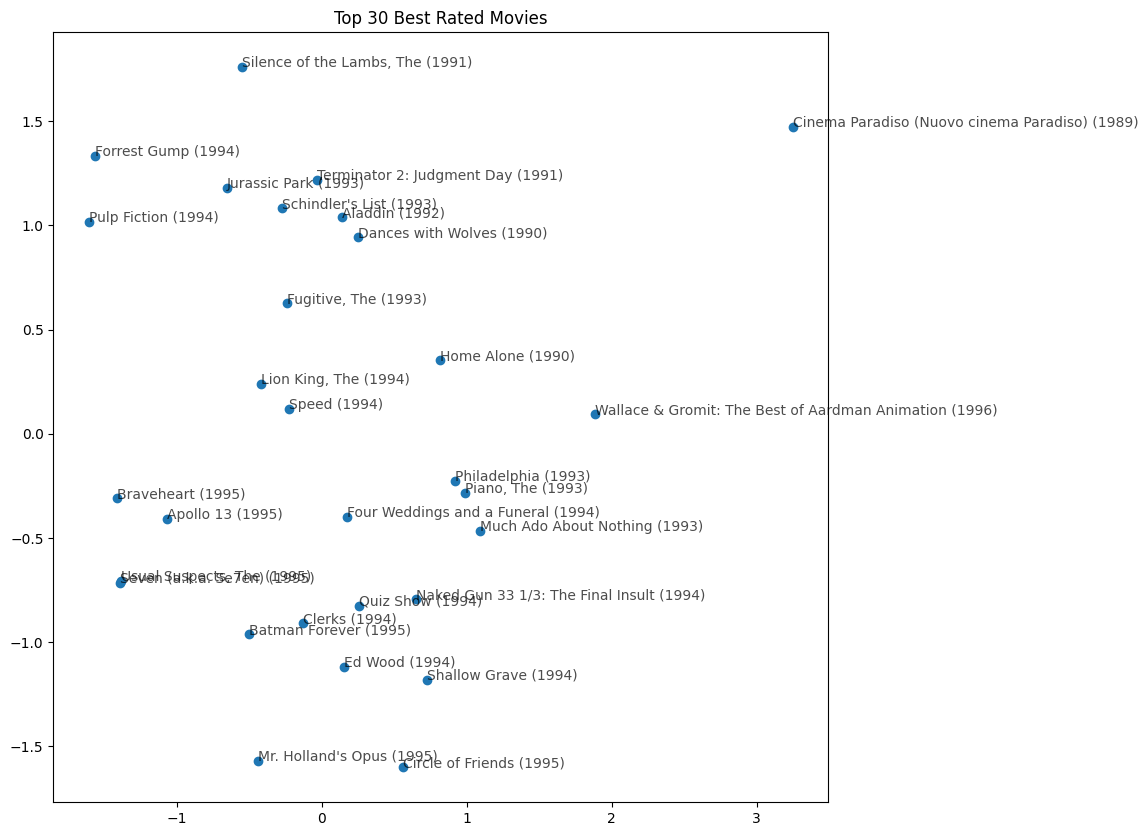

In [ ]:
plt.figure(figsize=(10,10))   # create the figure
plt.scatter(data_pca[:, 0], data_pca[:, 1])

# give it names
annotations = [movie[1] for movie in top_30]     # this line of code is generated with chatgpt to fix error
for i, label in enumerate(annotations):
    plt.annotate(label, (data_pca[i, 0], data_pca[i, 1]), alpha=0.7)

plt.title('Top 30 Best Rated Movies')

In [ ]:
# I realize that this is not based on movie_embeddings, but I ran out of time. Bear with me :'(